### Known Data :

In [ ]:
from scipy.io import loadmat, savemat

# Load a .mat file
data = loadmat('/content/burgers_shock.mat')
print(data.keys())  # View variable names in the

data


dict_keys(['__header__', '__version__', '__globals__', 'x', 't', 'usol'])


{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Sep 20 16:38:22 2017',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[-1.        ],
        [-0.99215686],
        [-0.98431373],
        [-0.97647059],
        [-0.96862745],
        [-0.96078431],
        [-0.95294118],
        [-0.94509804],
        [-0.9372549 ],
        [-0.92941176],
        [-0.92156863],
        [-0.91372549],
        [-0.90588235],
        [-0.89803922],
        [-0.89019608],
        [-0.88235294],
        [-0.8745098 ],
        [-0.86666667],
        [-0.85882353],
        [-0.85098039],
        [-0.84313725],
        [-0.83529412],
        [-0.82745098],
        [-0.81960784],
        [-0.81176471],
        [-0.80392157],
        [-0.79607843],
        [-0.78823529],
        [-0.78039216],
        [-0.77254902],
        [-0.76470588],
        [-0.75686275],
        [-0.74901961],
        [-0.74117647],
        [-0.73333333],
        [-0.7254902 ],
        [-0.71764706],
        

In [ ]:
data['usol'].shape

(256, 100)

256 Data points, goverened by the Burger Equation

In [ ]:
u_star

NameError: name 'u_star' is not defined

In [ ]:
X

NameError: name 'X' is not defined

### Final code :

In [ ]:
# @title Default title text
import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd

# Purpose: Import necessary libraries for numerical computation, deep learning, data handling, and visualization.

# Load the simulation data for the Burgers' equation
# Purpose: Load spatial (x), temporal (t), and solution (Exact) data from a .mat file.
data = scipy.io.loadmat('/content/burgers_shock.mat')
# flattening the data to have 1-D arrays as inputs:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']) # Exact is a 2D array having values of u for each time point t (rows) and spatial point x (columns)


# Prepare training data
# Purpose: Create a dataset by combining spatial and temporal coordinates with their corresponding solution values.
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

In [ ]:
X_star.shape

(25600, 2)

Iteration 0, Loss: 0.48593522880811707
Iteration 100, Loss: 0.3640184548529944
Iteration 200, Loss: 0.3629164265560034
Iteration 300, Loss: 0.3588146838003845


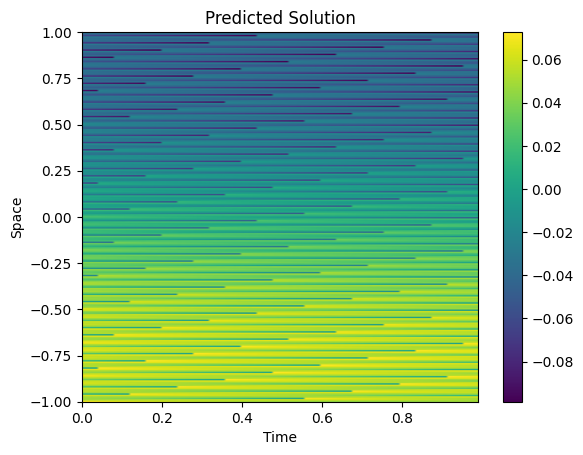

In [ ]:
# @title Default title text
import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd

# Purpose: Import necessary libraries for numerical computation, deep learning, data handling, and visualization.

# Load the simulation data for the Burgers' equation
# Purpose: Load spatial (x), temporal (t), and solution (Exact) data from a .mat file.
data = scipy.io.loadmat('/content/burgers_shock.mat')
# flattening the data to have 1-D arrays as inputs:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']) # Exact is a 2D array having values of u for each time point t (rows) and spatial point x (columns)


# Prepare training data
# Purpose: Create a dataset by combining spatial and temporal coordinates with their corresponding solution values.
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]




# Collocation points (RAndomly sampled from training data)
# Purpose: Randomly sample training points from the dataset for computational efficiency.
N_train = 2000 # number of collocation points
idx = np.random.choice(X_star.shape[0], N_train, replace=False)  # randomly sampling collocation pts from trainng data
X_train = X_star[idx, :]
u_train = u_star[idx, :]



# converting to tensors
u_train = tf.convert_to_tensor(u_train, dtype=tf.double)
X_train = tf.convert_to_tensor(X_train, dtype=tf.double)




class PhysicsInformedNN:
    # Purpose: Define a class for the Physics-Informed Neural Network (PINN).
    def __init__(self, X_train, u_train, layers):
        # Store training data and network architecture
        self.X_train = X_train
        self.u_train = u_train
        self.layers = layers

        # Initialize neural network parameters (weights and biases)
        self.weights, self.biases = self.initialize_NN(layers)

        # Set up the optimizer
        self.optimizer = tf.keras.optimizers.Adam()



    def initialize_NN(self, layers):
        # Purpose: Initialize the neural network using Xavier initialization.
        weights = []
        biases = []
        for l in range(len(layers) - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])  # number of neurons on layer l * number of neurons in layer l+1
          # biases are initialised to zero
          # biases is given as an tf variable hence a trainable param
          # the size of the bias tensor is because of the size of x*w so that we can find x*w + b
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.double))
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        # Purpose: Generate weights using Xavier initialization for proper scaling.
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.double), dtype=tf.double)


    def forward_pass(self, X):
        # Purpose: Define the forward pass through the neural network.
        A = X
        for l in range(len(self.weights) - 1):
            W = self.weights[l]
            b = self.biases[l]
            A = tf.tanh(tf.add(tf.matmul(A, W), b))  # Activation function: tanh (for dense layers)
            #print(f"Layer {l}: A.shape = {A.shape}")
        W = self.weights[-1]
        b = self.biases[-1]
        output = tf.add(tf.matmul(A, W), b)  # Linear output layer
        #print(f"Output: {output.shape}")
        return output


    def compute_pde_residual(self, X):
        # Convert input to TensorFlow tensor with gradient tracking
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(X)
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch(X)
                u = self.forward_pass(X)

            # First derivatives
            u_x = tape1.gradient(u, X)[:, 0:1]
            u_t = tape1.gradient(u, X)[:, 1:2]

        # Second derivative
        u_xx = tape2.gradient(u_x, X)[:, 0:1]

        # Compute PDE residual (Burgers' equation)
        f = u_t + tf.multiply(u, u_x) - (0.01/np.pi) * u_xx

        return f


    def compute_loss(self):  # fucntion to calculate the total loss

        # Purpose: Compute the total loss as a combination of data loss and physics loss.
        u_pred = self.forward_pass(self.X_train) # for data loss
        f_pred = self.compute_pde_residual(self.X_train)  # for Physics loss
      # total loss func:
        loss = tf.reduce_mean(tf.square(self.u_train - u_pred)) + tf.reduce_mean(tf.square(f_pred))
        return loss

    def train(self, nIter):
        # Purpose: Train the network by minimizing the total loss using gradient descent.
        for it in range(nIter): # iterating for epochs = nIter
            with tf.GradientTape() as tape: # to calculate gradients for physics loss
                loss = self.compute_loss()
            gradients = tape.gradient(loss, self.weights + self.biases) # gradients for final optimization of the total loss
            self.optimizer.apply_gradients(zip(gradients, self.weights + self.biases)) # passing the params to be used to optimize as a single listz

            if it % 100 == 0:
                print(f"Iteration {it}, Loss: {loss.numpy()}")

    def predict(self, X_star):
        # Purpose: Use the trained network to predict solutions for new data points.
        u_pred = self.forward_pass(X_star)
        return u_pred.numpy()

# Define the neural network architecture
layers = [2, 20, 20, 20, 20, 1]  # Input layer, hidden layers, and output layer

# Create and train the model
# Purpose: Instantiate the PINN model and train it on the sampled data.
model = PhysicsInformedNN(X_train, u_train, layers)
model.train(400)  # Train for 10,000 iterations

# Predict the solution for the entire domain
# Purpose: Generate predictions for the full dataset and visualize the results.
u_pred = model.predict(X_star)

# Reshape and visualize the results
U_pred = u_pred.reshape(Exact.shape)
plt.imshow(U_pred, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Predicted Solution')
plt.xlabel('Time')
plt.ylabel('Space')
plt.show()



In [ ]:
X.shape

(100, 256)

In [ ]:
Exact.shape

(256, 100)

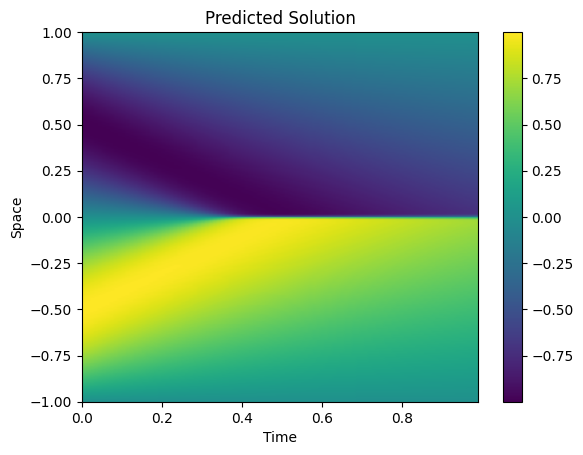

In [ ]:


plt.imshow(Exact, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
plt.colorbar()
plt.title('Actual Solution')
plt.xlabel('Time')
plt.ylabel('Space')
plt.show()


In [ ]:
Exact.shape


(256, 100)

In [ ]:
x.shape

(256, 1)

In [ ]:
t.shape

(100, 1)